**Facial Keypoints Detection**

**Pipeline**

1. Import the relevant packages
2. Import Data
3. Define the class that prepares the dataset
4. Define the model, loss function and optimizer
5. Train the model over increasing epochs

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np, pandas as pd
import os, glob, cv2
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.model_selection import train_test_split

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

**Download and Import Data**

In [3]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 6049 (delta 3), reused 7 (delta 2), pack-reused 6038 (from 1)
Receiving objects: 100% (6049/6049), 329.53 MiB | 37.89 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [4]:
len(all_img_paths)

3462

In [5]:
data.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [6]:
class FacesData(Dataset):
  def __init__(self, df):
    super(FacesData).__init__()
    self.df = df

    self.normalize = transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )

  def __len__(self):
    return len(self.df)

  def __getitem__(self, ix):
    img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix, 0]
    img = cv2.imread(img_path)/255   # scale the image
    kp = deepcopy(self.df.iloc[ix,1:].tolist())
    kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
    kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
    kp2 = kp_x + kp_y
    kp2 = torch.tensor(kp2)
    img = self.preprocess_input(img)
    return img, kp2
  def preprocess_input(self, img):
    img = cv2.resize(img, (224,224))
    img = torch.tensor(img).permute(2,0,1)
    img = self.normalize(img).float()
    return img.to(device)
  def load_img(self, ix):
    img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
    img = cv2.imread(img_path)
    img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
    img = cv2.resize(img, (224,224))
    return img

In [7]:
train, test = train_test_split(data, test_size=0.2, random_state=101)
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
len(train_loader), len(test_loader),

(87, 22)

In [9]:
len(train_dataset), len(test_dataset)

(2769, 693)

**Model**

In [10]:
def get_model():
  model = models.vgg16(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False

  model.avgpool = nn.Sequential(
      nn.Conv2d(512, 512, 3),
      nn.MaxPool2d(2),
      nn.Flatten()
  )
  model.classifier = nn.Sequential(
      nn.Linear(2048, 512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512, 136),
      nn.Sigmoid()
  )

  criterion = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  return model.to(device), criterion, optimizer

In [11]:
model, criterion, optimizer = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 132MB/s]


In [12]:
def train_batch(img, kps, model, optimizer, criterion):
  model.train()
  optimizer.zero_grad()
  _kps = model(img.to(device))
  loss = criterion(_kps, kps.to(device))
  loss.backward()
  optimizer.step()
  return loss

In [13]:
@torch.no_grad()

def validate_batch(img, kps, model, criterion):
  model.eval()
  with torch.no_grad():
    _kps = model(img.to(device))
  loss = criterion(_kps, kps.to(device))
  return _kps, loss

**Model Training**

In [14]:
train_loss, test_loss = [], []
n_epochs = 50

for epoch in range(n_epochs):
    print(f" Epoch {epoch + 1} / 50")
    epoch_train_loss, epoch_test_loss = 0, 0
    for ix, (img,kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()
    epoch_train_loss /= (ix+1)

    for ix,(img,kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        epoch_test_loss += loss.item()
    epoch_test_loss /= (ix+1)

    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_test_loss)

    print(f'Training Loss: {epoch_train_loss:.4f}')
    print(f'Testing Loss: {epoch_test_loss:.4f}')


 Epoch 1 / 50
Training Loss: 0.0587
Testing Loss: 0.0341
 Epoch 2 / 50
Training Loss: 0.0413
Testing Loss: 0.0271
 Epoch 3 / 50
Training Loss: 0.0347
Testing Loss: 0.0267
 Epoch 4 / 50
Training Loss: 0.0318
Testing Loss: 0.0252
 Epoch 5 / 50
Training Loss: 0.0290
Testing Loss: 0.0249
 Epoch 6 / 50
Training Loss: 0.0275
Testing Loss: 0.0216
 Epoch 7 / 50
Training Loss: 0.0263
Testing Loss: 0.0217
 Epoch 8 / 50
Training Loss: 0.0248
Testing Loss: 0.0225
 Epoch 9 / 50
Training Loss: 0.0239
Testing Loss: 0.0210
 Epoch 10 / 50
Training Loss: 0.0224
Testing Loss: 0.0209
 Epoch 11 / 50
Training Loss: 0.0221
Testing Loss: 0.0220
 Epoch 12 / 50
Training Loss: 0.0213
Testing Loss: 0.0215
 Epoch 13 / 50
Training Loss: 0.0210
Testing Loss: 0.0243
 Epoch 14 / 50
Training Loss: 0.0208
Testing Loss: 0.0205
 Epoch 15 / 50
Training Loss: 0.0216
Testing Loss: 0.0204
 Epoch 16 / 50
Training Loss: 0.0213
Testing Loss: 0.0202
 Epoch 17 / 50
Training Loss: 0.0209
Testing Loss: 0.0203
 Epoch 18 / 50
Training

**Save model weights**

In [15]:
torch.save(model.state_dict(), 'model_weights.pth')

**Plotting Training and Test Loss Over Increasing Epochs**

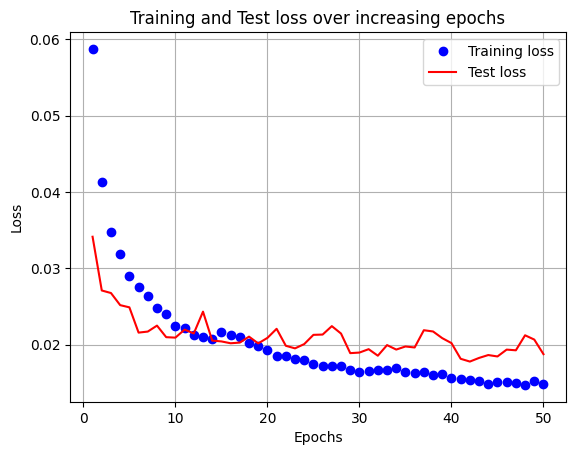

In [16]:
epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.ticker as mticker

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

**Test model on random test image**

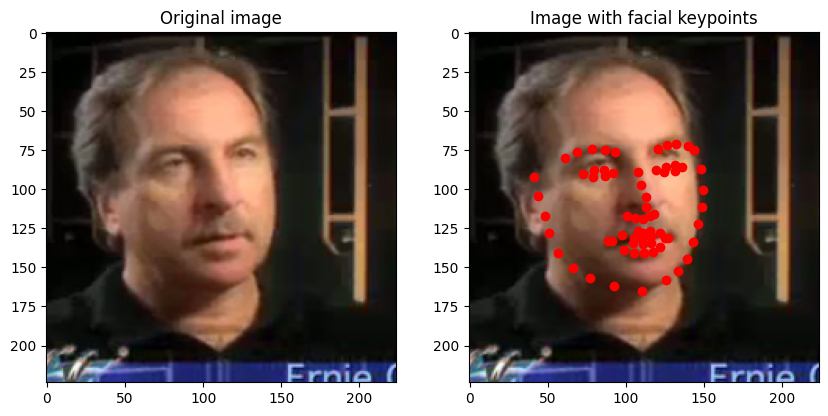

In [22]:
ix = 9
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_img(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

Load the model for CPU inference

In [ ]:
# Initialize the model architecture
model, _, _ = get_model()

model.load_state_dict(torch.load('model_weights.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode (important for inference)
model.eval()